## Google Research - Identify Contrails to Reduce Global Warming

### Import modules

In [1]:
# basic modules
import pandas as pd
import numpy as np
import datetime
import os
from tqdm import tqdm

import random

# Visualization
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython import display

# pytorch modules
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import BCELoss, Sigmoid
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau 
from torchvision.transforms import Normalize
from torch.multiprocessing import Pool
import torch.nn as nn
from collections import OrderedDict
from torch.optim import lr_scheduler

In [2]:
base_dir = "/kaggle/input/google-research-identify-contrails-reduce-global-warming/"
train_path = os.path.join(base_dir,"train")
test_path = os.path.join(base_dir,"test")
val_path = os.path.join(base_dir,"validation")

train_ids = os.listdir(train_path)
#train_ids = np.loadtxt("/kaggle/input/train-ids-existcontrail/train_ids_ExistContrail.csv", delimiter=",", dtype = "unicode")
#train_ids = train_ids.tolist()

test_ids = os.listdir(test_path)
val_ids = os.listdir(val_path)

### Combine bands into a false color image (ASH Transform)

[In order to view contrails in GOES, we use the "ash" color scheme. This color scheme was originally developed for viewing volcanic ash in the atmosphere but is also useful for viewing thin cirrus, including contrails. In this color scheme, contrails appear in the image as dark blue.](https://www.kaggle.com/code/inversion/visualizing-contrails)

- `Input` = np.ndarray of shape `(Bands=3, Time_frame=8, H=256, W=256)` where Bands corresponds to bands `[11, 14, 15]`.
- `Output` = np.ndarray of shape `(Time_frame=8, Channel=3, H=256, W=256)` where Channel corresponds to rgb colorscheme.

In [3]:
def ash_transform(x, time_frame:int=4):
    _T11_BOUNDS = (243, 303)
    _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
    _TDIFF_BOUNDS = (-4, 2)
    if time_frame is not None:
        x = x[:,time_frame,:,:]
    def normalize_range(data, bounds):
        """Maps data to the range [0, 1]."""
        return (data - bounds[0]) / (bounds[1] - bounds[0])

    r = normalize_range(x[2] - x[1], _TDIFF_BOUNDS)
    g = normalize_range(x[1] - x[0], _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(x[1], _T11_BOUNDS)
    
    return np.clip(np.stack([r, g, b], axis=-3), 0, 1) # (T,3,H,W) or (3,H,W)

Augmentation (by GPT)

In [4]:

def random_horizontal_flip(video):
    if random.random() < 0.5:
        return video[..., ::-1]
    return video

def random_vertical_flip(video):
    if random.random() < 0.5:
        return video[..., ::-1, :]
    return video

def random_mask(img, mask_size=10, musk_num=20):
    i = 0
    for i in range(musk_num):
        if random.random() < 0.5:
            h, w = img.shape[-2:]
            top = random.randint(0, h - mask_size)
            left = random.randint(0, w - mask_size)
            img[..., top:top+mask_size, left:left+mask_size] = 0
            i += 1
    return img

def augment_video(video):
    #video = random_vertical_flip(video)  #正解データも反転させないとダメでは？
    #print(video.shape)
    video = np.stack([random_mask(frame) for frame in video.transpose(1, 0, 2, 3)])

    return video.transpose(1, 0, 2, 3)


# Test with dummy data
#video = np.random.rand(3, 10, 224, 224)
#augmented_video = augment_video(video)


### CustomDataset and DataLoader

- `ids` = record ids
- `base_dir` = path to parent(train/val/test) dir
- `bands` = list of integers corresponding bands(band_xx.npy). Default:loads all bands 
- `transforms` = list of function applied to np.ndarray of shape `(Band, Time_frame, H, W)`
- `Output` = torch.tensor, dtype = `torch.float32`

In [5]:
class ContrailDataset(Dataset):
    def __init__(self, ids, base_dir, bands=None, transforms:list=[], test_mode:bool=False, aug=False):
        self.ids = ids
        self.base_dir = base_dir
        self.transforms = transforms
        self.bands = bands
        self.permute = (2,0,1)
        self.test_mode = test_mode
        self.aug = aug
        
    def __getitem__(self, index):
        record_id = self.ids[index]
        
        if self.bands is None:
            band_list = [f'band_{band:02d}.npy' for band in range(8,17)]
        else :
            band_list = [f'band_{int(band):02d}.npy' for band in self.bands]
        
        x = list()
        for band in band_list:
            x_path = os.path.join(self.base_dir, record_id, band)
            x.append(np.load(x_path).transpose(self.permute))

        x = np.stack(x,axis=1) ## X.shape = (Time_frame,channel,H,W)
        
        x = x.transpose((1,0,2,3)) ## PLUS ## X.shape = (channel, Time_frame ,H,W)
        
        #print(x.shape)
        
        if self.aug:
            #print(x.shape)
            x = augment_video(x)
            #x = random_mask(x)
        
        
        for transformation in self.transforms:
            x = transformation(x)
            

        
        x = torch.from_numpy(x.astype(np.float32))
        
        if self.test_mode:
            return x
        else:
            y_path = os.path.join(self.base_dir, record_id,'human_pixel_masks.npy')
            y = torch.from_numpy(np.load(y_path).transpose(self.permute).astype(np.float32))

            return x, y

    def __len__(self):
        return len(self.ids)
        
    

### Initiate Dataset and DataLoader

In [6]:
# Datasets 
dataset_params = {
    "bands" : [11,14,15], 
    "transforms" : [ash_transform]
}
train_dataset = ContrailDataset(train_ids, train_path, **dataset_params, aug=True)
test_dataset = ContrailDataset(test_ids, test_path, test_mode=True, **dataset_params)
val_dataset = ContrailDataset(val_ids, val_path, **dataset_params)

# DalaLoaders
dataloader_params = {
    "batch_size" : 16,
    "shuffle" : True,
    "num_workers": 4,
    "drop_last": True
#     "pin_memory": True

}
train_loader = DataLoader(train_dataset, **dataloader_params)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=2)
val_loader = DataLoader(val_dataset, **dataloader_params)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualization

In [7]:
def plot_contrail(x, y, time_frame = 4):
    '''
    x = false color img of shape (8, 3, H, W)
    y = contrail mask of shape (1, H, W)
    time_frame = int, default = 4
    '''
    if x.ndim == 4:
        x = x[time_frame]
    
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(1, 3, 1)
    ax.imshow(x.permute(1,2,0))
    ax.set_title('False color image')

    ax = plt.subplot(1, 3, 2)
    ax.imshow(y.permute(1,2,0), interpolation='none')
    ax.set_title('Ground truth contrail mask')

    ax = plt.subplot(1, 3, 3)
    ax.imshow(x.permute(1,2,0))
    ax.imshow(y.permute(1,2,0), cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('Contrail mask on false color image');

    plt.show()

def plot_contrail_comparision(x, y_true, y_pred, time_frame = 4):
    '''
    x = false color img of shape (3, H, W) or (8, 3, H, W)
    y_true = target contrail mask of shape (1, H, W)
    y_pred = predicted contrail mask of shape (1, H, W)
    time_frame = int, default = 4
    '''
    if x.ndim == 4:
        x = x[time_frame]
    
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(1, 5, 1)
    ax.imshow(x.permute(1,2,0))
    ax.set_title('False color image(x)')
    ax.axis('off')
    
    ax = plt.subplot(1, 5, 2)
    ax.imshow(y_true.permute(1,2,0), interpolation='none')
    ax.set_title('True contrail mask(y_true)')
    ax.axis('off')
    
    ax = plt.subplot(1, 5, 3)
    ax.imshow(x.permute(1,2,0))
    ax.imshow(y_true.permute(1,2,0), cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('y_true mask on x')
    ax.axis('off')
    
    ax = plt.subplot(1, 5, 4)
    ax.imshow(y_pred.permute(1,2,0), interpolation='none')
    ax.set_title('Pred contrail mask(y_pred)')
    ax.axis('off')

    ax = plt.subplot(1, 5, 5)
    ax.imshow(x.permute(1,2,0))
    ax.imshow(y_pred.permute(1,2,0), cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('y_pred mask on x')
    ax.axis('off')
    
    plt.show()

def animate_contrail(x):
    '''
    x = false color img of shape (8, 3, H, W)
    '''
    if x.ndim !=4:
        print(f"Incorrect input dimensions, Expected 4 recievied {x.ndim}.")
        return
    # Animation
    fig = plt.figure(figsize=(4, 4))
    im = plt.imshow(x[0].permute(1,2,0))
    def draw(i):
        im.set_array(x[i].permute(1,2,0))
        return [im]
    anim = animation.FuncAnimation(
        fig, draw, frames=x.shape[0], interval=100, blit=True
    )
    plt.close()
    return display.HTML(anim.to_jshtml())

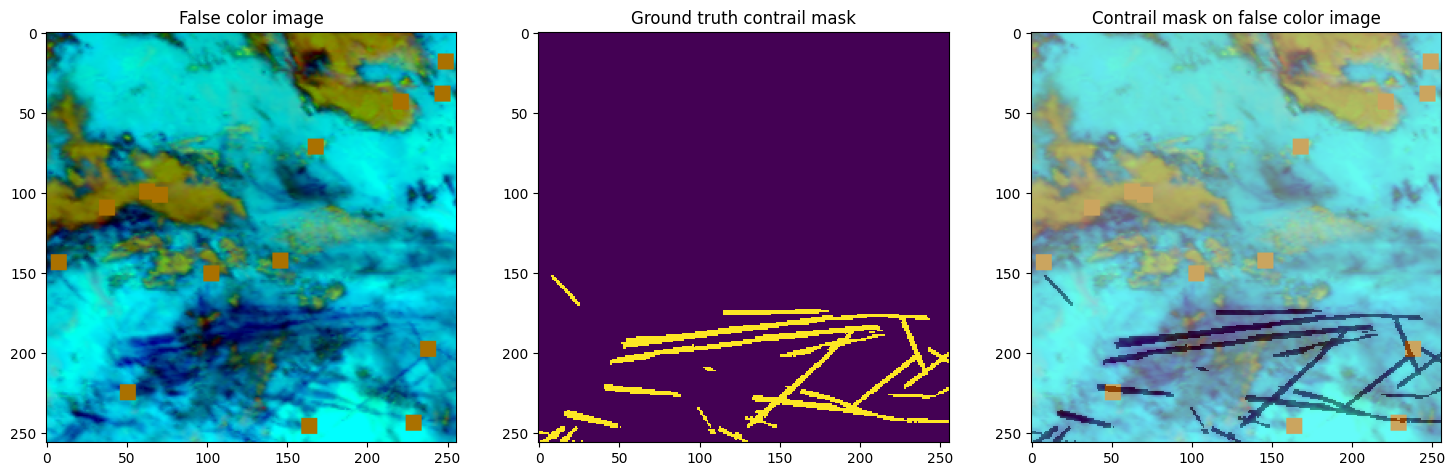

Incorrect input dimensions, Expected 4 recievied 3.


In [8]:
 x, y = train_dataset[train_ids.index('1704010292581573769')]
 plot_contrail(x, y)
 animate_contrail(x)

### Essential functions
- Dice coefficient
- Callbacks to track loss and other params
- Callbacks to save best state

In [9]:
# Dice Coefficient
def dice_coeff(mask1, mask2):
    intersect = torch.sum(mask1 * mask2)
    m1sum = torch.sum(mask1)
    m2sum = torch.sum(mask2)
    dice = (2 * intersect ) / (m1sum + m2sum)
    return dice.item()

# # Example
# mask1 = torch.randint(0,2,(10, 256,256))
# mask2 = torch.randint(0,2,(10, 256,256))
# print(dice_coeff(mask1, mask2))

In [10]:
# Callbacks
class History:
    def __init__(self, print_prefix, save_to_disk=True):
        self.train_batch_history = []
        self.val_batch_histroy = []
        self.train_epoch_history = []
        self.val_epoch_history = []
        self.running_train_batch_history = []
        self.running_val_batch_history = []
        self.print_prefix = print_prefix
        self.save_to_disk = save_to_disk
        if save_to_disk:
            self.save_path = os.path.join(os.getcwd(),"saved_states",self.print_prefix)
            if not os.path.exists(self.save_path):
                os.makedirs(self.save_path)
    def on_train_batch_end(self, data):
        self.running_train_batch_history.append(data)
        
    def on_val_batch_end(self, data):
        self.running_val_batch_history.append(data)
        
    def on_epoch_end(self):
        self.train_epoch_history.append(np.mean(self.running_train_batch_history))
        self.train_batch_history.extend(self.running_train_batch_history)
        self.running_train_batch_history=[]
        self.val_epoch_history.append(np.mean(self.running_val_batch_history))
        self.val_batch_histroy.extend(self.running_val_batch_history)
        self.running_val_batch_history=[]
        print(f"{self.print_prefix}: Train = {self.train_epoch_history[-1]:.6f} \
        | Val = {self.val_epoch_history[-1]:.6f}")
    
    def on_end(self):
        if self.save_to_disk:
            #dt = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
            np.save(os.path.join(self.save_path,"train_batch.npy"),self.train_batch_history)
            np.save(os.path.join(self.save_path,"val_batch.npy"),self.val_batch_histroy)
            np.save(os.path.join(self.save_path,"train_epoch.npy"),self.train_epoch_history)
            np.save(os.path.join(self.save_path,"val_epoch.npy"),self.val_epoch_history)

In [11]:
class BestStateTracker:
    def __init__(self, model, optim, trigger:History, save_to_disk:bool = False):
        self.trigger = trigger
        self.model = model
        self.optim = optim
        self.optim_state = None
        self.model_state = None
        self.best_loss = np.inf
        self.save_to_disk = save_to_disk
        if save_to_disk:
            self.save_path = os.path.join(os.getcwd(),"saved_states")
            if not os.path.exists(self.save_path):
                os.mkdir(self.save_path)
                
    def on_epoch_end(self):
        if self.trigger.val_epoch_history[-1] < self.best_loss:
            self.model_state = self.model.state_dict()
            self.optim_state = self.optim.state_dict()
            
    def on_end(self):
        if self.save_to_disk:
            #dt = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
            torch.save(self.model_state,os.path.join(self.save_path,f"model_state_end.pt"))
            torch.save(self.optim_state,os.path.join(self.save_path,f"optim_state_end.pt"))

### Model Architecture

In [12]:
# Config
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LR = 6e-3
EPOCHS = 15

In [13]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, dilations):
        super(ASPP, self).__init__()
        self.aspp_blocks = nn.ModuleList()
        for dilation in dilations:
            self.aspp_blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation, bias=False),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True))
                )

    def forward(self, x):
        return sum(block(x) for block in self.aspp_blocks)


In [14]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = ASPP(features * 8, features * 16, dilations=[1, 6, 12, 18])

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name, dropout_rate=0.25):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (name + "dropout1", nn.Dropout(dropout_rate)),   # Dropout layer added
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                    (name + "dropout2", nn.Dropout(dropout_rate)),  # Dropout layer added
                ]
            )
        )


In [15]:
class Focal_MultiLabel_Loss(nn.Module):
    def __init__(self, gamma):
      super(Focal_MultiLabel_Loss, self).__init__()
      self.gamma = gamma
      self.bceloss = nn.BCELoss(reduction='none')

    def forward(self, outputs, targets): 
      bce = self.bceloss(outputs, targets)
      bce_exp = torch.exp(-bce)
      focal_loss = (1-bce_exp)**self.gamma * bce
      return focal_loss.mean()

In [16]:
model = UNet().to(DEVICE)

'''model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                       in_channels=3, out_channels=1, init_features=32, 
                       pretrained=False).to(DEVICE)'''
optimizer = Adam(params=model.parameters(), lr=LR)

#loss_fn = BCELoss()
loss_fn = Focal_MultiLabel_Loss(gamma=2) 


#scheduler = ReduceLROnPlateau(optimizer)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
loss_tracker = History(print_prefix="Loss")
dice_tracker = History(print_prefix="Dice")
save_state = BestStateTracker(model,optimizer,loss_tracker,save_to_disk=True)

In [17]:
model.load_state_dict(torch.load("/kaggle/input/unet-training/saved_states/model_state_end.pt",map_location=torch.device(DEVICE)))

<All keys matched successfully>

### Model Train

  0%|          | 0/15 [00:00<?, ?it/s]


EPOCH: 1/15
Epoch: 1, Learning rate: 0.006


Train Batch: 1283/1283     | Loss: 0.004863:   0%|          | 0/15 [10:11<?, ?it/s]

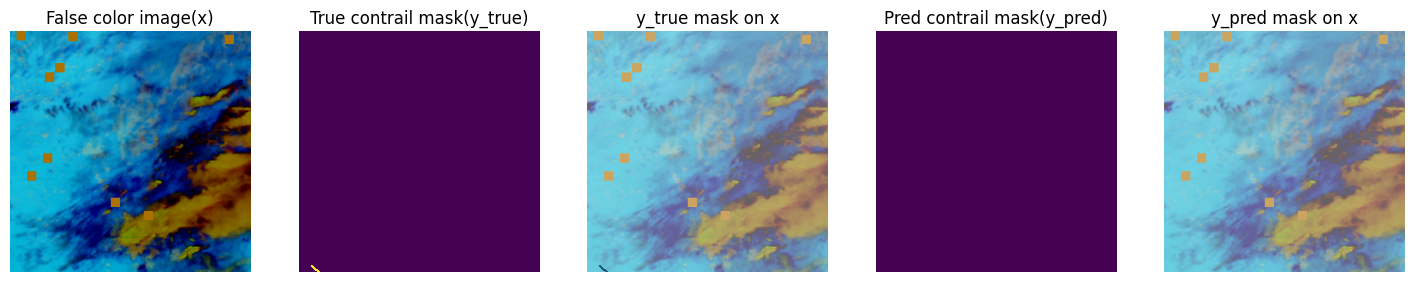

Val Batch:   116/116         | Loss: 0.000596:   0%|          | 0/15 [10:59<?, ?it/s]

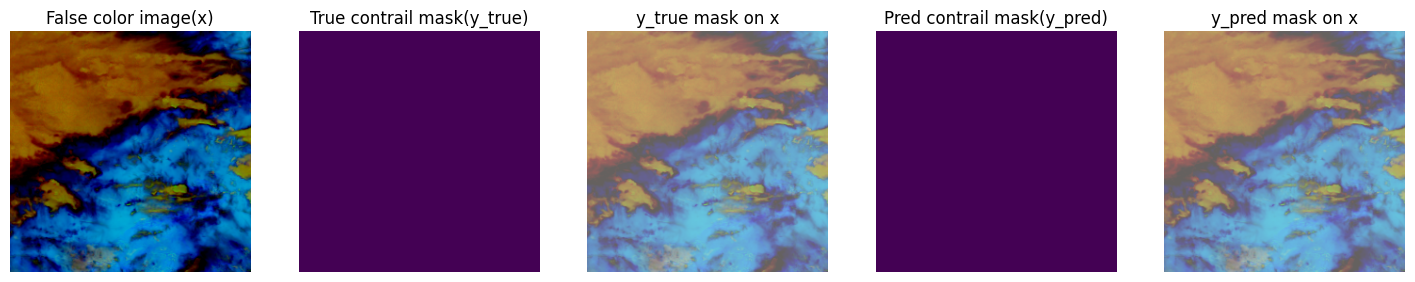

Val Batch:   116/116         | Loss: 0.000596:   7%|▋         | 1/15 [10:59<2:33:57, 659.86s/it]

Train sample(above), Val sample(below)
Loss: Train = 0.003072         | Val = 0.001885
Dice: Train = 0.529776         | Val = 0.297232

EPOCH: 2/15
Epoch: 2, Learning rate: 0.005934442802201417


Train Batch: 1283/1283     | Loss: 0.002126:   7%|▋         | 1/15 [21:00<2:33:57, 659.86s/it]

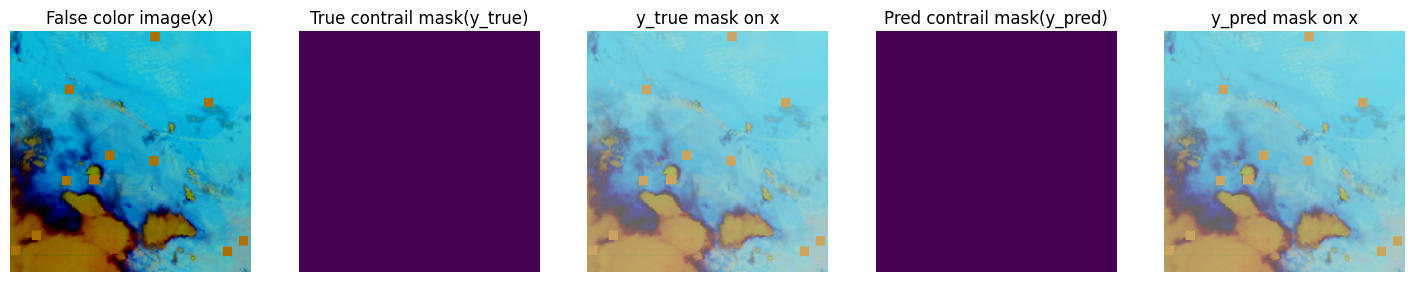

Val Batch:   116/116         | Loss: 0.000976:   7%|▋         | 1/15 [21:48<2:33:57, 659.86s/it]

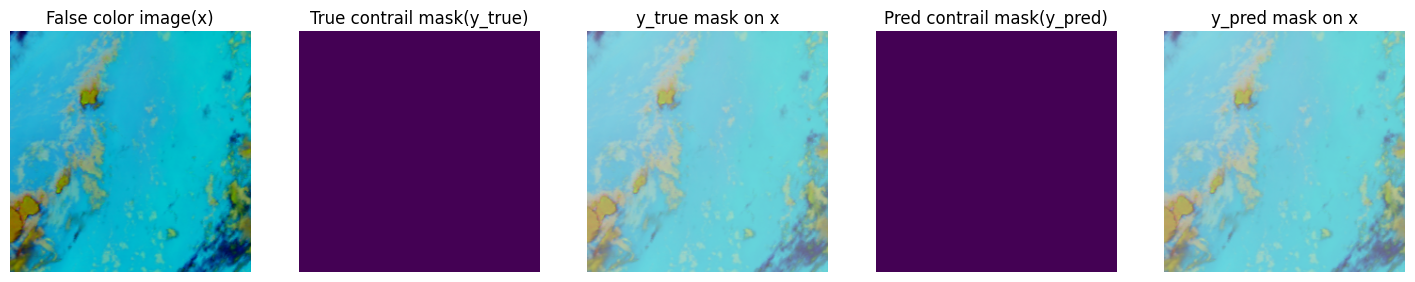

Val Batch:   116/116         | Loss: 0.000976:  13%|█▎        | 2/15 [21:48<2:21:33, 653.38s/it]

Train sample(above), Val sample(below)
Loss: Train = 0.003044         | Val = 0.001403
Dice: Train = 0.534600         | Val = 0.407401

EPOCH: 3/15
Epoch: 3, Learning rate: 0.005740636372927803


Train Batch: 1283/1283     | Loss: 0.000610:  13%|█▎        | 2/15 [31:42<2:21:33, 653.38s/it]

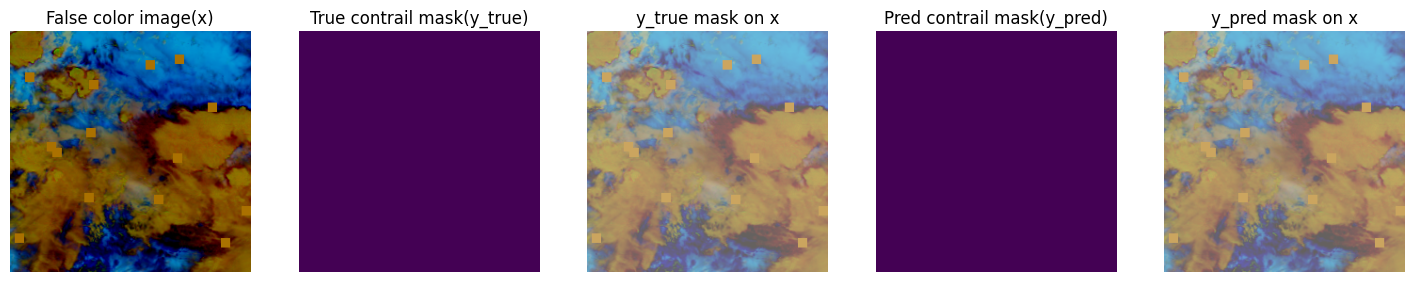

Val Batch:   116/116         | Loss: 0.000560:  13%|█▎        | 2/15 [32:27<2:21:33, 653.38s/it]

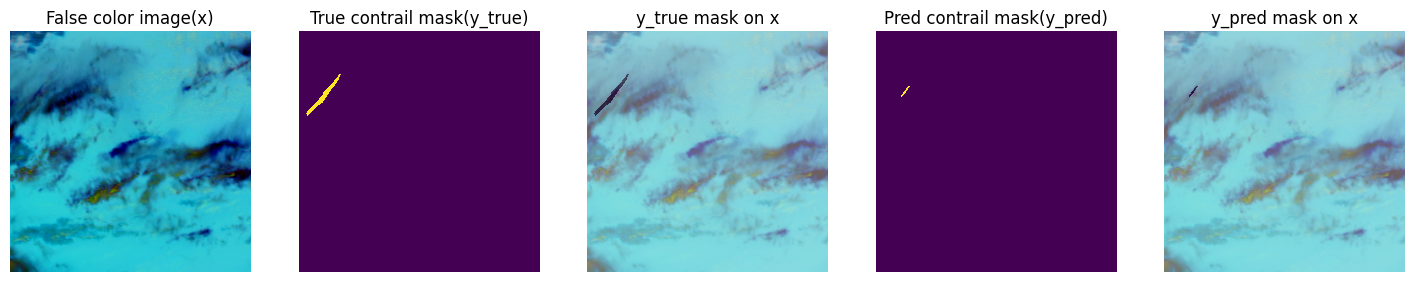

Val Batch:   116/116         | Loss: 0.000560:  20%|██        | 3/15 [32:28<2:09:24, 647.04s/it]

Train sample(above), Val sample(below)
Loss: Train = 0.003013         | Val = 0.001639
Dice: Train = 0.537123         | Val = 0.370161

EPOCH: 4/15
Epoch: 4, Learning rate: 0.005427050983124843


Train Batch: 1283/1283     | Loss: 0.002006:  20%|██        | 3/15 [42:15<2:09:24, 647.04s/it]

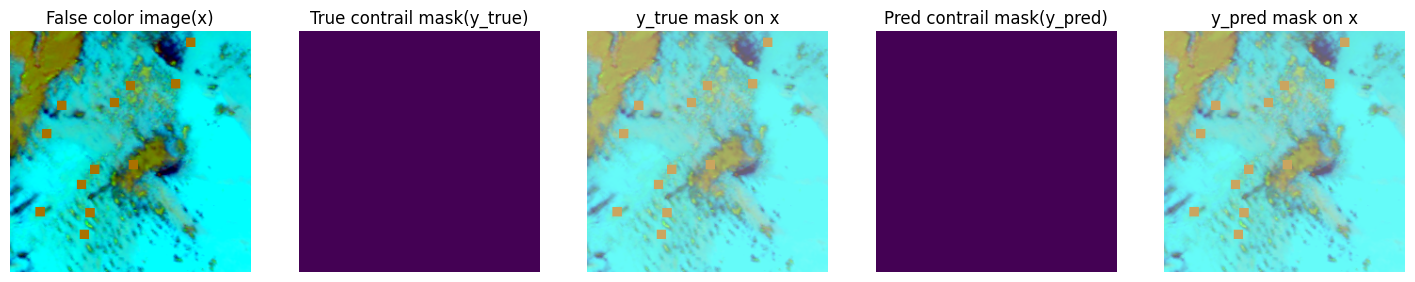

Val Batch:   116/116         | Loss: 0.002710:  20%|██        | 3/15 [43:00<2:09:24, 647.04s/it]

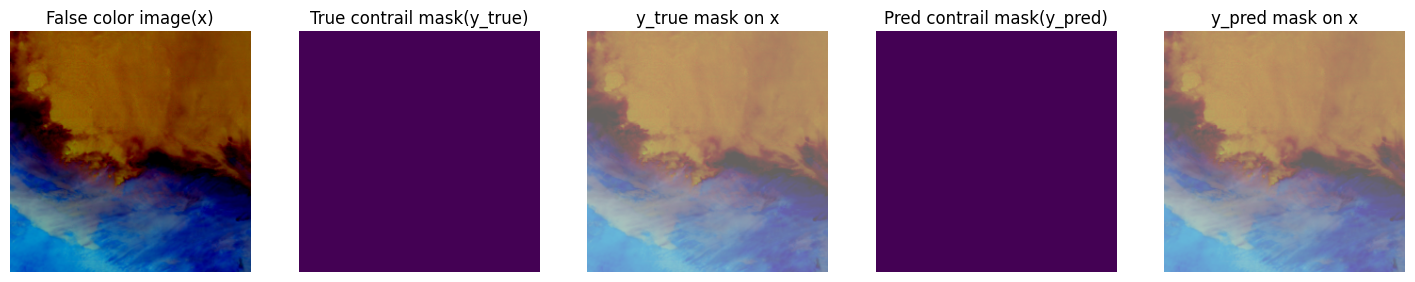

Val Batch:   116/116         | Loss: 0.002710:  27%|██▋       | 4/15 [43:01<1:57:35, 641.44s/it]

Train sample(above), Val sample(below)
Loss: Train = 0.002957         | Val = 0.001410
Dice: Train = 0.545103         | Val = nan

EPOCH: 5/15
Epoch: 5, Learning rate: 0.005007391819076576


Train Batch: 1283/1283     | Loss: 0.003542:  27%|██▋       | 4/15 [52:48<1:57:35, 641.44s/it]

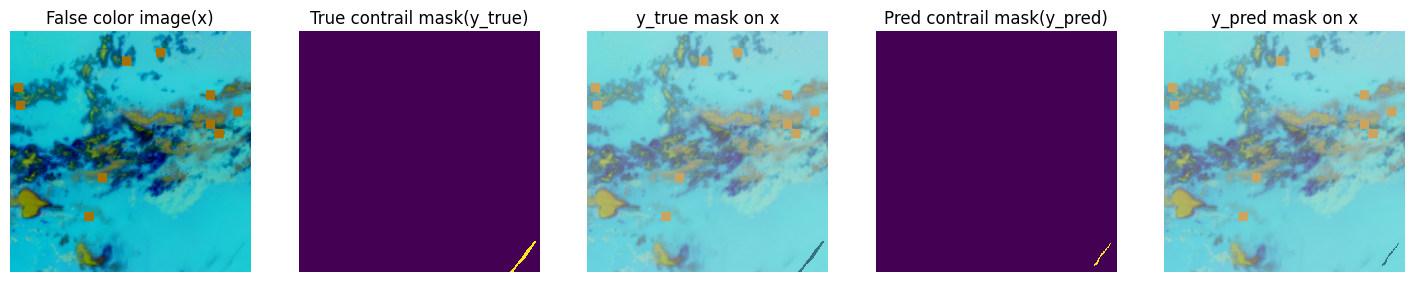

Val Batch:   116/116         | Loss: 0.001486:  27%|██▋       | 4/15 [53:33<1:57:35, 641.44s/it]

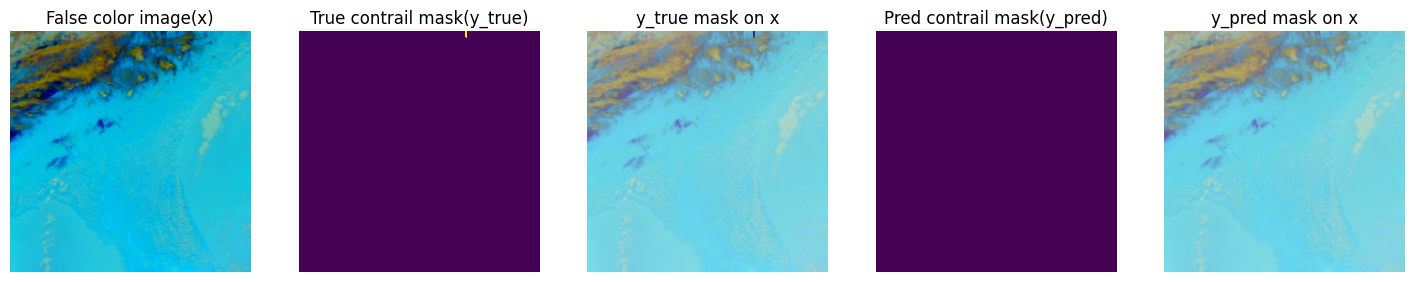

Val Batch:   116/116         | Loss: 0.001486:  33%|███▎      | 5/15 [53:34<1:46:24, 638.41s/it]

Train sample(above), Val sample(below)
Loss: Train = 0.002917         | Val = 0.001363
Dice: Train = nan         | Val = 0.424852

EPOCH: 6/15
Epoch: 6, Learning rate: 0.0045000000000000005


Train Batch: 1283/1283     | Loss: 0.001264:  33%|███▎      | 5/15 [1:03:28<1:46:24, 638.41s/it]

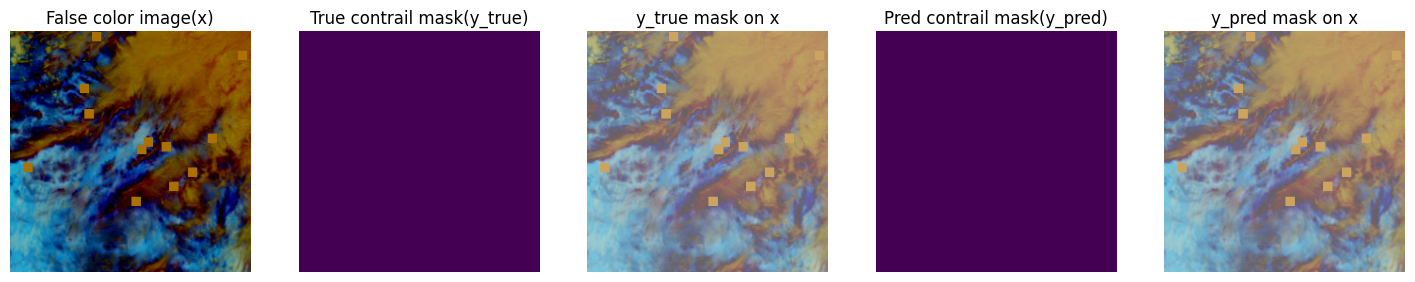

Val Batch:   116/116         | Loss: 0.001617:  33%|███▎      | 5/15 [1:04:13<1:46:24, 638.41s/it]

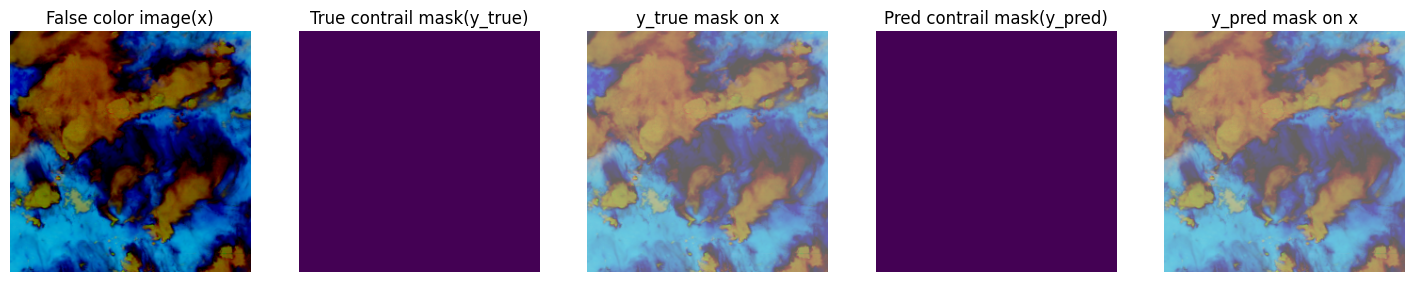

Val Batch:   116/116         | Loss: 0.001617:  40%|████      | 6/15 [1:04:14<1:35:52, 639.11s/it]

Train sample(above), Val sample(below)
Loss: Train = 0.002873         | Val = 0.001486
Dice: Train = 0.554614         | Val = 0.380543

EPOCH: 7/15
Epoch: 7, Learning rate: 0.003927050983124843


Train Batch: 1283/1283     | Loss: 0.002666:  40%|████      | 6/15 [1:14:18<1:35:52, 639.11s/it]

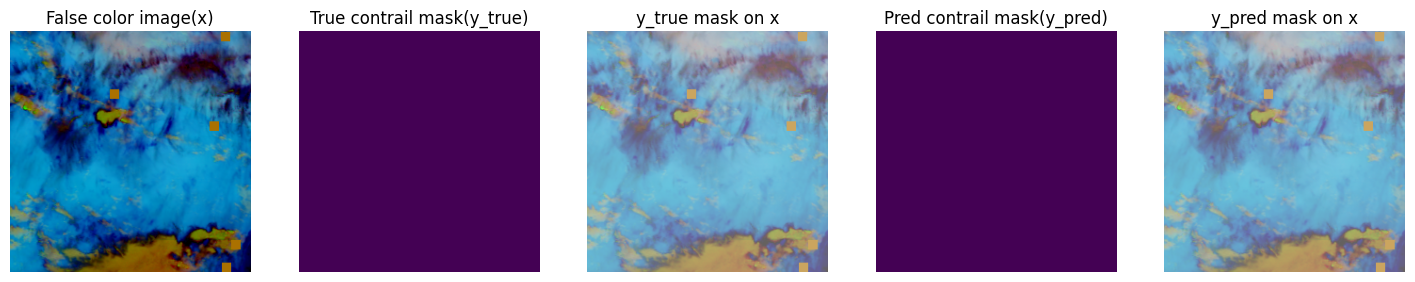

Val Batch:   116/116         | Loss: 0.001523:  40%|████      | 6/15 [1:15:05<1:35:52, 639.11s/it]

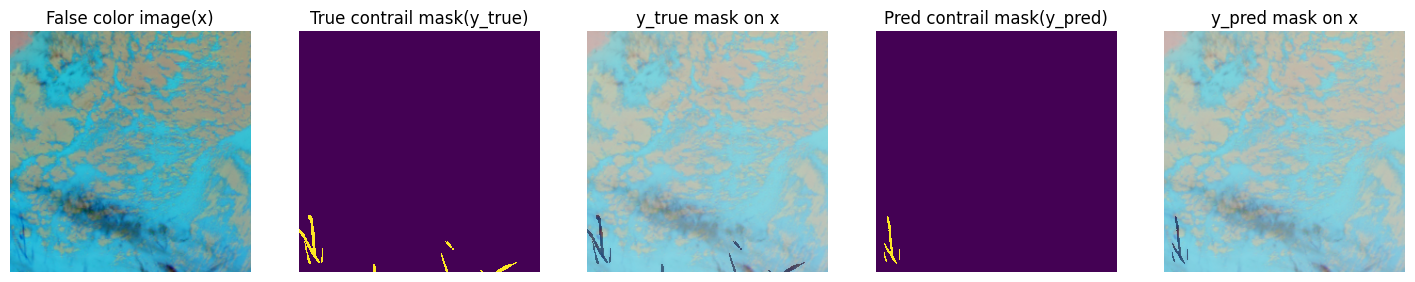

Val Batch:   116/116         | Loss: 0.001523:  47%|████▋     | 7/15 [1:15:05<1:25:44, 643.06s/it]

Train sample(above), Val sample(below)
Loss: Train = 0.002817         | Val = 0.001486
Dice: Train = 0.565426         | Val = 0.428403

EPOCH: 8/15
Epoch: 8, Learning rate: 0.0033135853898029616


Train Batch: 1283/1283     | Loss: 0.001809:  47%|████▋     | 7/15 [1:24:58<1:25:44, 643.06s/it]

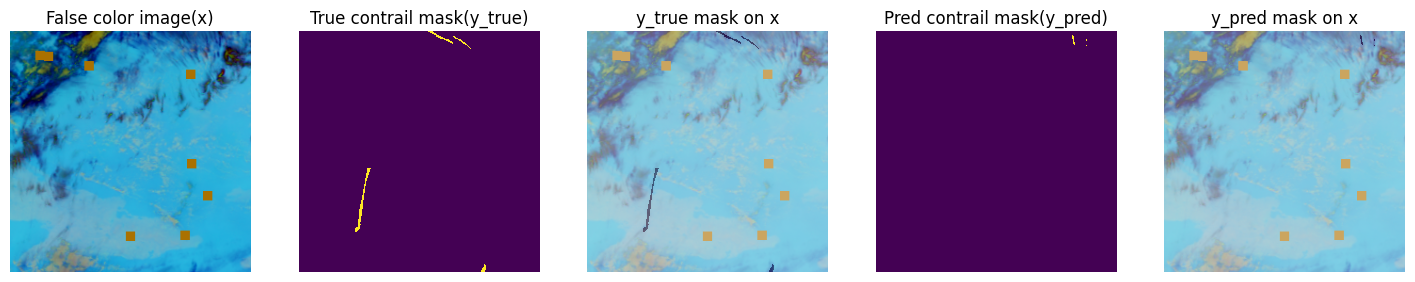

Val Batch:   116/116         | Loss: 0.000351:  47%|████▋     | 7/15 [1:25:44<1:25:44, 643.06s/it]

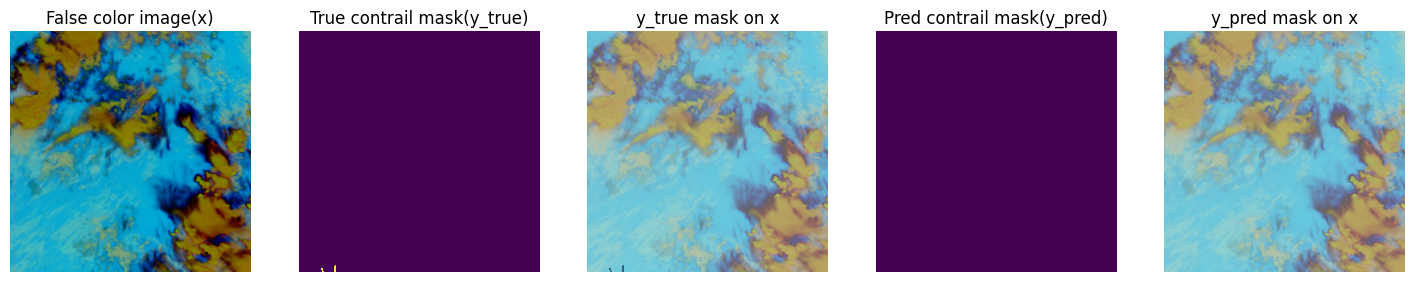

Val Batch:   116/116         | Loss: 0.000351:  53%|█████▎    | 8/15 [1:25:44<1:14:52, 641.83s/it]

Train sample(above), Val sample(below)
Loss: Train = 0.002755         | Val = 0.001448
Dice: Train = 0.568831         | Val = 0.405169

EPOCH: 9/15
Epoch: 9, Learning rate: 0.002686414610197041


Train Batch: 1283/1283     | Loss: 0.001393:  53%|█████▎    | 8/15 [1:35:43<1:14:52, 641.83s/it]

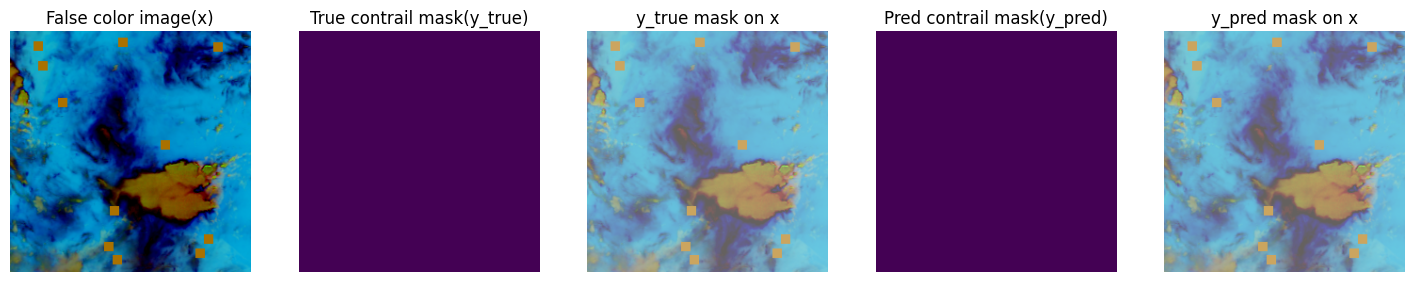

Val Batch:   116/116         | Loss: 0.000425:  53%|█████▎    | 8/15 [1:36:29<1:14:52, 641.83s/it]

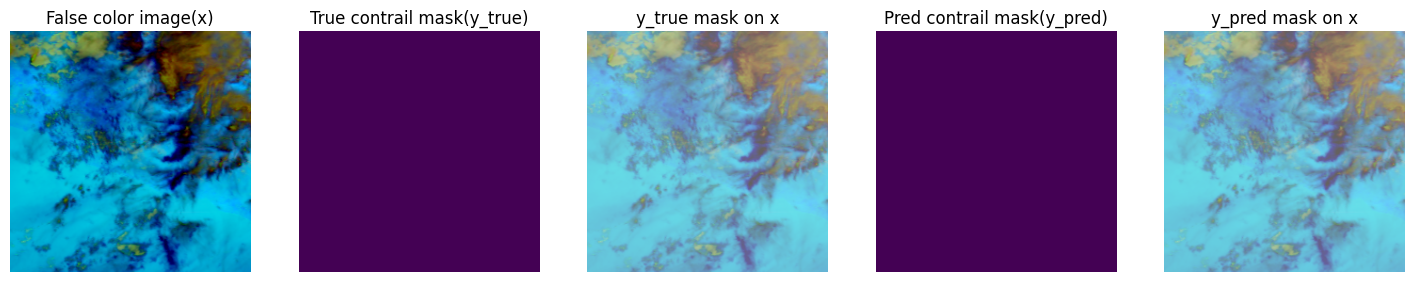

Val Batch:   116/116         | Loss: 0.000425:  60%|██████    | 9/15 [1:36:29<1:04:16, 642.72s/it]

Train sample(above), Val sample(below)
Loss: Train = 0.002702         | Val = 0.001549
Dice: Train = 0.580612         | Val = 0.395941

EPOCH: 10/15
Epoch: 10, Learning rate: 0.002072949016875159


Train Batch: 1283/1283     | Loss: 0.004138:  60%|██████    | 9/15 [1:46:36<1:04:16, 642.72s/it]

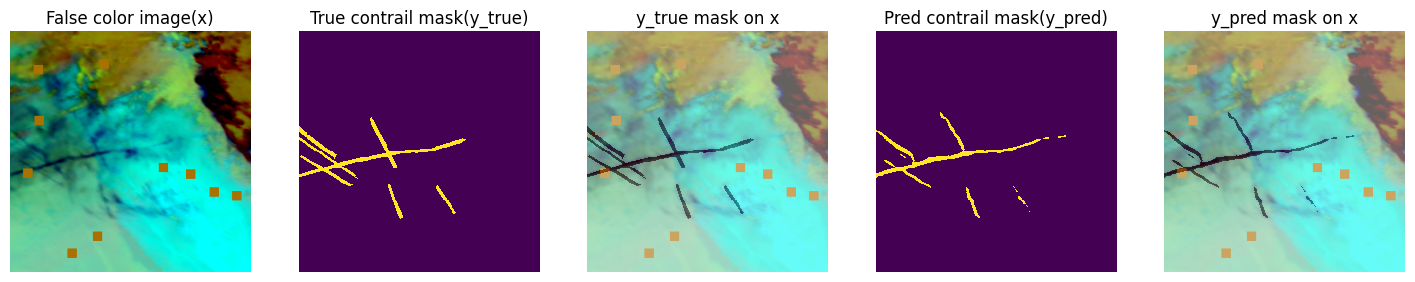

Val Batch:   116/116         | Loss: 0.000849:  60%|██████    | 9/15 [1:47:23<1:04:16, 642.72s/it]

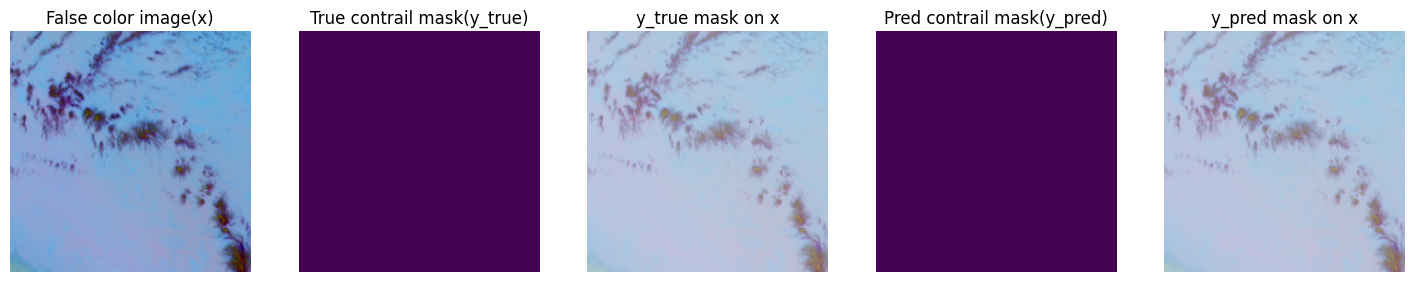

Val Batch:   116/116         | Loss: 0.000849:  67%|██████▋   | 10/15 [1:47:24<53:51, 646.33s/it] 

Train sample(above), Val sample(below)
Loss: Train = 0.002647         | Val = 0.001513
Dice: Train = 0.585363         | Val = nan

EPOCH: 11/15
Epoch: 11, Learning rate: 0.0015000000000000013


Train Batch: 1283/1283     | Loss: 0.002840:  67%|██████▋   | 10/15 [1:57:36<53:51, 646.33s/it]

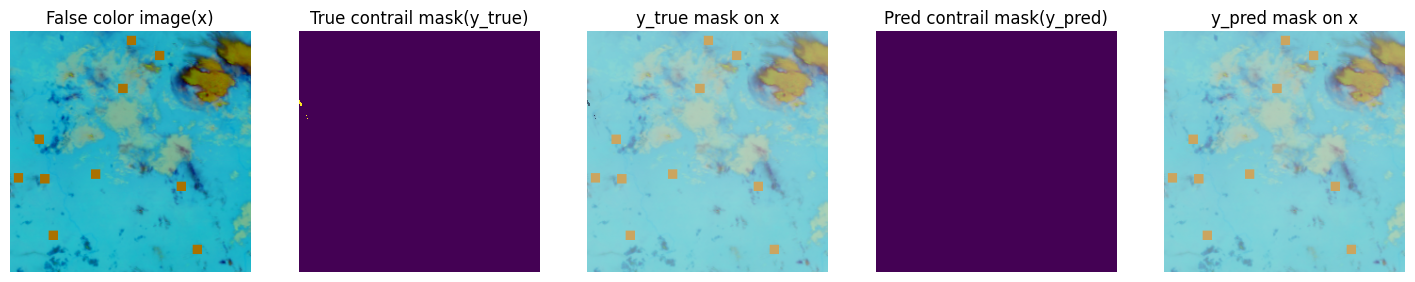

Val Batch:   116/116         | Loss: 0.000731:  67%|██████▋   | 10/15 [1:58:23<53:51, 646.33s/it]

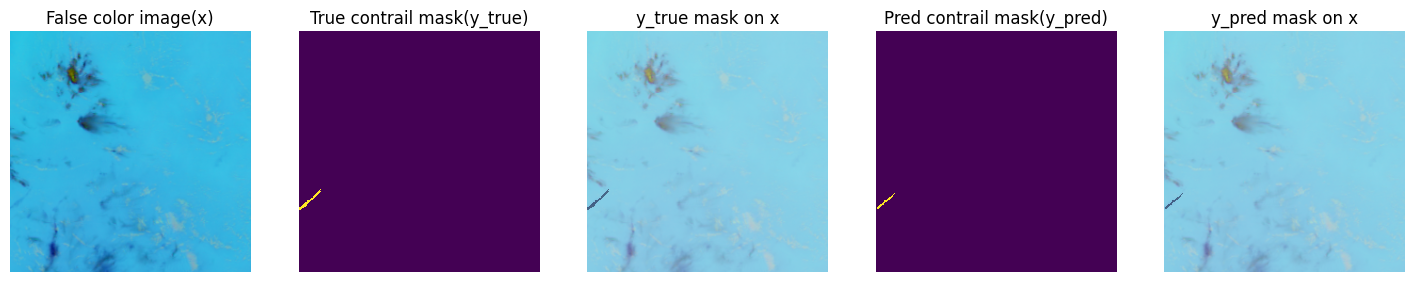

Val Batch:   116/116         | Loss: 0.000731:  73%|███████▎  | 11/15 [1:58:23<43:21, 650.40s/it]

Train sample(above), Val sample(below)
Loss: Train = 0.002597         | Val = 0.001581
Dice: Train = 0.592106         | Val = 0.399305

EPOCH: 12/15
Epoch: 12, Learning rate: 0.0009926081809234267


Train Batch: 1283/1283     | Loss: 0.001986:  73%|███████▎  | 11/15 [2:08:32<43:21, 650.40s/it]

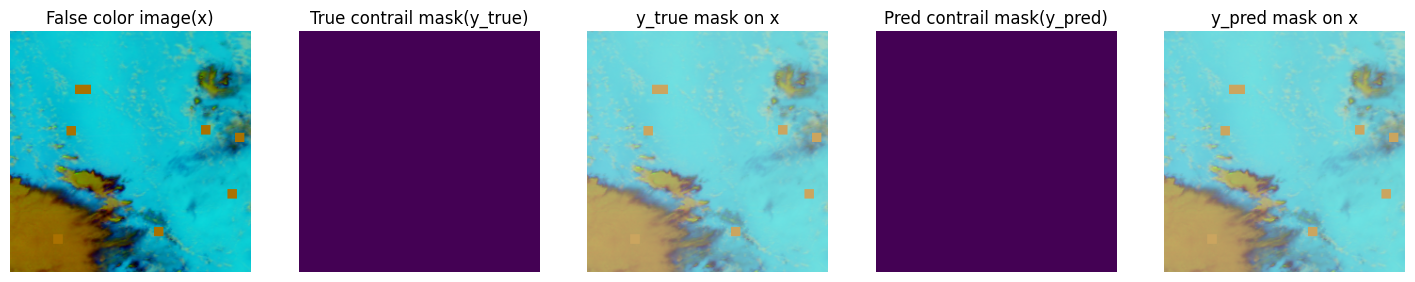

Val Batch:   116/116         | Loss: 0.003172:  73%|███████▎  | 11/15 [2:09:18<43:21, 650.40s/it]

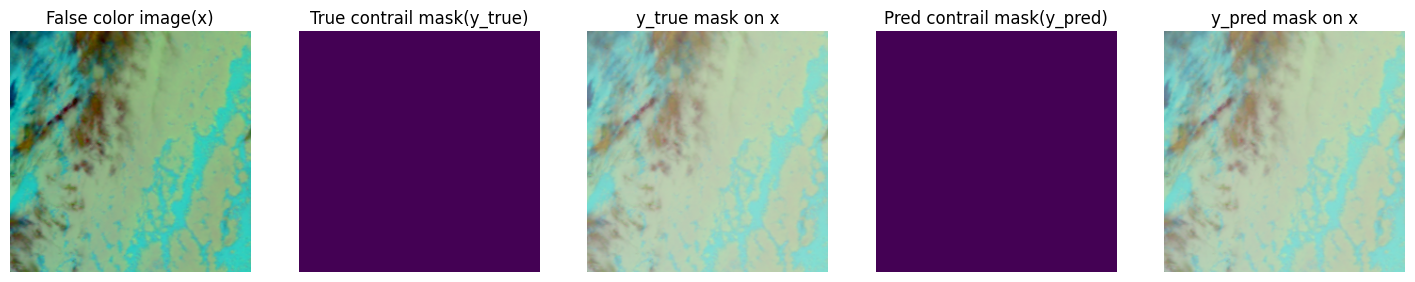

Val Batch:   116/116         | Loss: 0.003172:  80%|████████  | 12/15 [2:09:18<32:35, 651.88s/it]

Train sample(above), Val sample(below)
Loss: Train = 0.002553         | Val = 0.001559
Dice: Train = 0.597744         | Val = 0.428900

EPOCH: 13/15
Epoch: 13, Learning rate: 0.0005729490168751582


Train Batch: 1283/1283     | Loss: 0.003410:  80%|████████  | 12/15 [2:19:20<32:35, 651.88s/it]

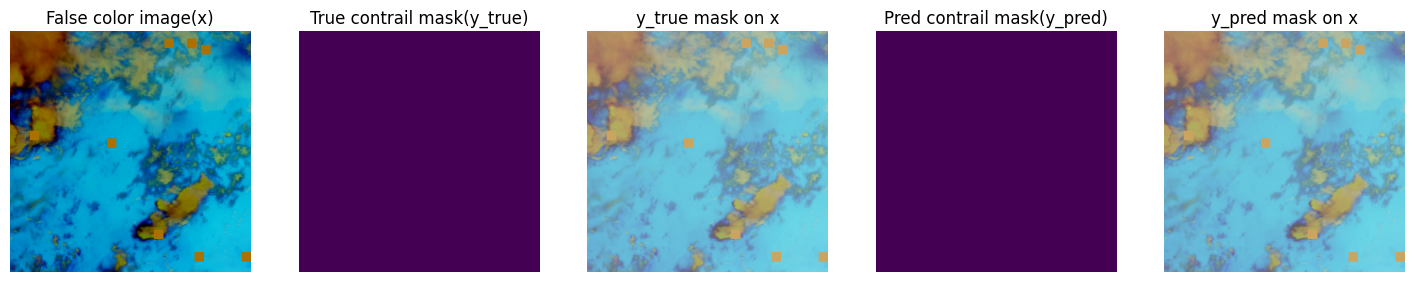

Val Batch:   116/116         | Loss: 0.001560:  80%|████████  | 12/15 [2:20:06<32:35, 651.88s/it]

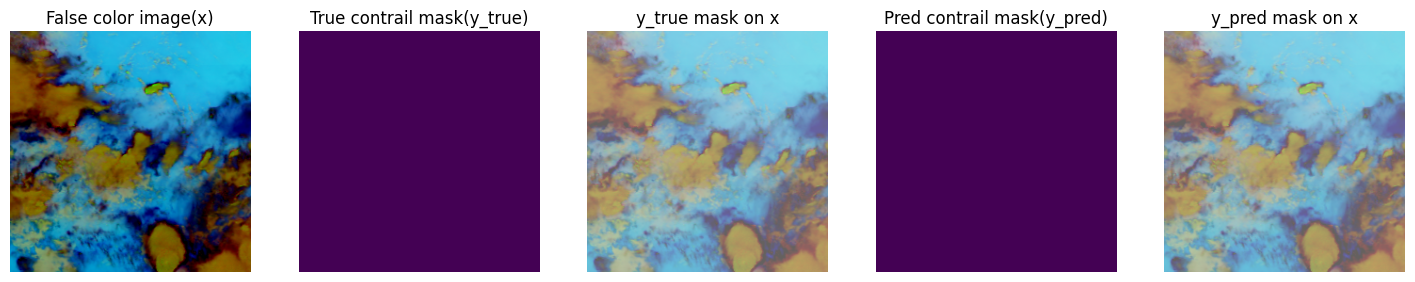

Val Batch:   116/116         | Loss: 0.001560:  87%|████████▋ | 13/15 [2:20:06<21:41, 650.71s/it]

Train sample(above), Val sample(below)
Loss: Train = 0.002520         | Val = 0.001644
Dice: Train = 0.602884         | Val = 0.432110

EPOCH: 14/15
Epoch: 14, Learning rate: 0.00025936362707219715


Train Batch: 1283/1283     | Loss: 0.001964:  87%|████████▋ | 13/15 [2:30:04<21:41, 650.71s/it]

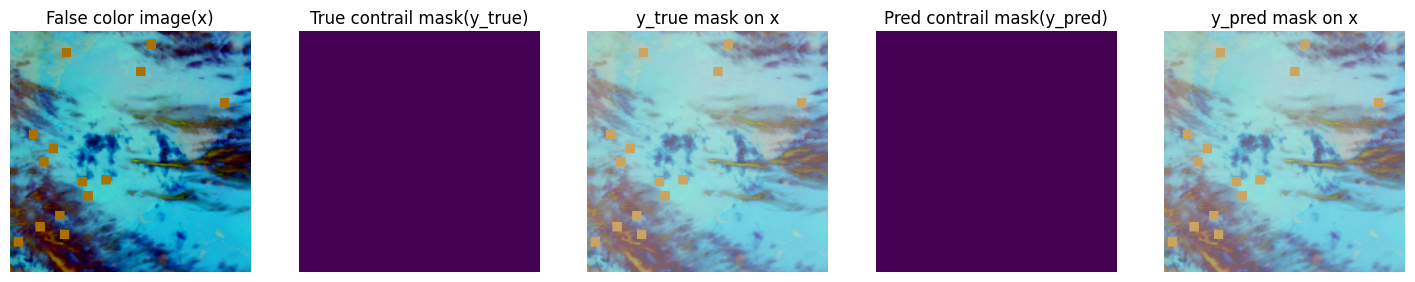

Val Batch:   116/116         | Loss: 0.005057:  87%|████████▋ | 13/15 [2:30:51<21:41, 650.71s/it]

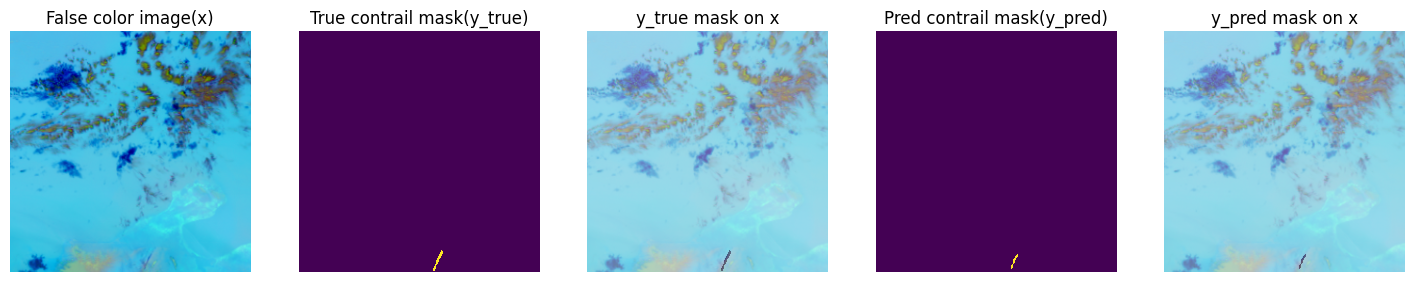

Val Batch:   116/116         | Loss: 0.005057:  93%|█████████▎| 14/15 [2:30:52<10:49, 649.02s/it]

Train sample(above), Val sample(below)
Loss: Train = 0.002501         | Val = 0.001511
Dice: Train = 0.609100         | Val = 0.449693

EPOCH: 15/15
Epoch: 15, Learning rate: 6.555719779858296e-05


Train Batch: 1283/1283     | Loss: 0.001720:  93%|█████████▎| 14/15 [2:40:53<10:49, 649.02s/it]

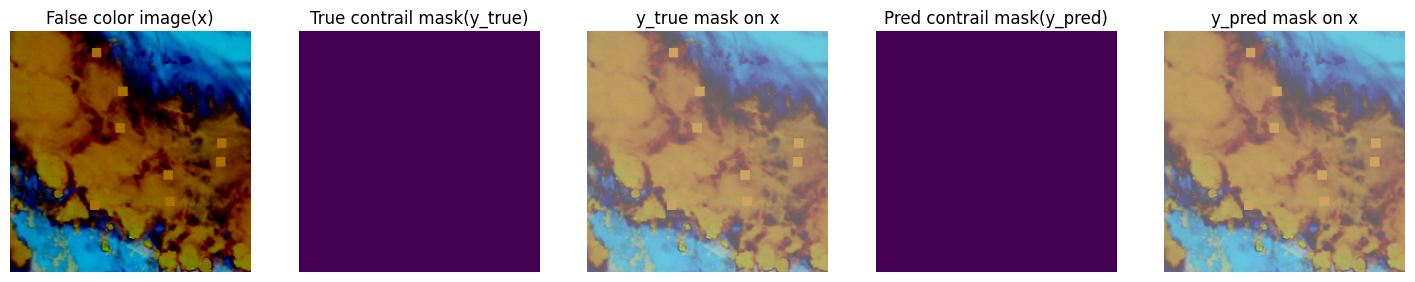

Val Batch:   116/116         | Loss: 0.001350:  93%|█████████▎| 14/15 [2:41:37<10:49, 649.02s/it]

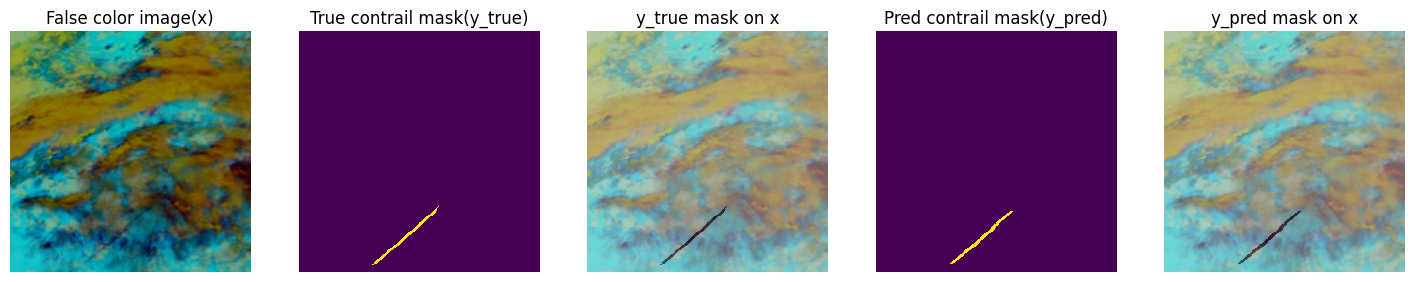

Val Batch:   116/116         | Loss: 0.001350: 100%|██████████| 15/15 [2:41:38<00:00, 646.54s/it]

Train sample(above), Val sample(below)
Loss: Train = 0.002482         | Val = 0.001585
Dice: Train = 0.610264         | Val = nan


In [18]:
pbar = tqdm(range(EPOCHS))

for epoch in pbar:
 print(f"\nEPOCH: {epoch+1}/{EPOCHS}")
 current_lr = optimizer.param_groups[0]['lr']
 print(f'Epoch: {epoch+1}, Learning rate: {current_lr}')
 model.train()
 for idx, (data, target) in enumerate(train_loader):
     data, target = data.to(DEVICE), target.to(DEVICE) #Copy to GPU if available
     y_pred = model(data)
     loss = loss_fn(y_pred, target)
     optimizer.zero_grad()
     loss.backward()
     optimizer.step()

     loss_tracker.on_train_batch_end(loss.item())
     dice_tracker.on_train_batch_end(dice_coeff(y_pred>0.5, target))
     pbar.set_description(f"Train Batch: {idx+1}/{len(train_loader)}\
     | Loss: {loss.item():.6f}")

 plot_contrail_comparision(data[0].cpu().detach(),
                           target[0].cpu().detach(),
                           y_pred[0].cpu().detach()>0.5)
 model.eval()    
 with torch.no_grad():
     for idx, (data, target) in enumerate(val_loader):
         data, target = data.to(DEVICE), target.to(DEVICE) #Copy to GPU if available
         y_pred = model(data)
         loss = loss_fn(y_pred, target)
         loss_tracker.on_val_batch_end(loss.item())
         dice_tracker.on_val_batch_end(dice_coeff(y_pred>0.5, target))
         pbar.set_description(f"Val Batch:   {idx+1}/{len(val_loader)}\
         | Loss: {loss.item():.6f}")

     plot_contrail_comparision(data[0].cpu().detach(),
                               target[0].cpu().detach(),
                               y_pred[0].cpu().detach()>0.5)
 print("Train sample(above), Val sample(below)")
 #scheduler.step(loss.item())
 scheduler.step()
 loss_tracker.on_epoch_end()
 dice_tracker.on_epoch_end()
 save_state.on_epoch_end()

save_state.on_end()
loss_tracker.on_end()
dice_tracker.on_end()

In [19]:
#torch.save(model.state_dict(),os.path.join(os.path.join(os.getcwd(),"saved_states"),f"bestmodel_state.pt"))

In [20]:
# Load pretrained states:
'''model.load_state_dict(torch.load("/kaggle/input/unet-trained-weights-contrails/contrails_save_states/saved_states/model_state_2023-05-12_06_31_20.pt",map_location=torch.device(DEVICE)))
optimizer.load_state_dict(torch.load("/kaggle/input/unet-trained-weights-contrails/contrails_save_states/saved_states/optim_state_2023-05-12_06_31_20.pt",map_location=torch.device(DEVICE)))
loss_tracker.train_batch_history=np.load("/kaggle/input/unet-trained-weights-contrails/contrails_save_states/saved_states/Loss/train_batch.npy")
loss_tracker.train_epoch_history=np.load("/kaggle/input/unet-trained-weights-contrails/contrails_save_states/saved_states/Loss/train_epoch.npy")
loss_tracker.val_batch_histroy=np.load("/kaggle/input/unet-trained-weights-contrails/contrails_save_states/saved_states/Loss/val_batch.npy")
loss_tracker.val_epoch_history=np.load("/kaggle/input/unet-trained-weights-contrails/contrails_save_states/saved_states/Loss/val_epoch.npy")
dice_tracker.train_batch_history=np.load("/kaggle/input/unet-trained-weights-contrails/contrails_save_states/saved_states/Dice/train_batch.npy")
dice_tracker.train_epoch_history=np.load("/kaggle/input/unet-trained-weights-contrails/contrails_save_states/saved_states/Dice/train_epoch.npy")
dice_tracker.val_batch_histroy=np.load("/kaggle/input/unet-trained-weights-contrails/contrails_save_states/saved_states/Dice/val_batch.npy")
dice_tracker.val_epoch_history=np.load("/kaggle/input/unet-trained-weights-contrails/contrails_save_states/saved_states/Dice/val_epoch.npy")'''


'model.load_state_dict(torch.load("/kaggle/input/unet-trained-weights-contrails/contrails_save_states/saved_states/model_state_2023-05-12_06_31_20.pt",map_location=torch.device(DEVICE)))\noptimizer.load_state_dict(torch.load("/kaggle/input/unet-trained-weights-contrails/contrails_save_states/saved_states/optim_state_2023-05-12_06_31_20.pt",map_location=torch.device(DEVICE)))\nloss_tracker.train_batch_history=np.load("/kaggle/input/unet-trained-weights-contrails/contrails_save_states/saved_states/Loss/train_batch.npy")\nloss_tracker.train_epoch_history=np.load("/kaggle/input/unet-trained-weights-contrails/contrails_save_states/saved_states/Loss/train_epoch.npy")\nloss_tracker.val_batch_histroy=np.load("/kaggle/input/unet-trained-weights-contrails/contrails_save_states/saved_states/Loss/val_batch.npy")\nloss_tracker.val_epoch_history=np.load("/kaggle/input/unet-trained-weights-contrails/contrails_save_states/saved_states/Loss/val_epoch.npy")\ndice_tracker.train_batch_history=np.load("/ka

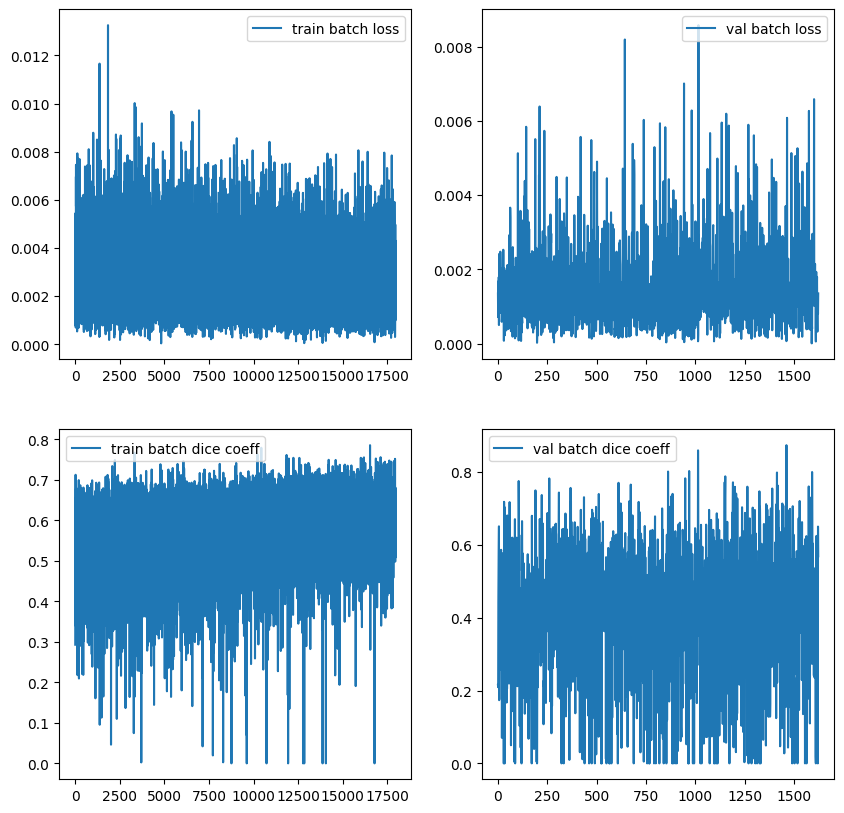

In [21]:
plt.figure(figsize=(10,10))
ax = plt.subplot(2,2,1)
ax.plot(loss_tracker.train_batch_history[len(train_loader):], label="train batch loss")
ax.legend()
ax = plt.subplot(2,2,2)
ax.plot(loss_tracker.val_batch_histroy[len(val_loader):], label="val batch loss")
ax.legend()
ax = plt.subplot(2,2,3)
ax.plot(dice_tracker.train_batch_history[len(train_loader):], label="train batch dice coeff")
ax.legend()
ax = plt.subplot(2,2,4)
ax.plot(dice_tracker.val_batch_histroy[len(val_loader):], label="val batch dice coeff")
ax.legend()
plt.show()

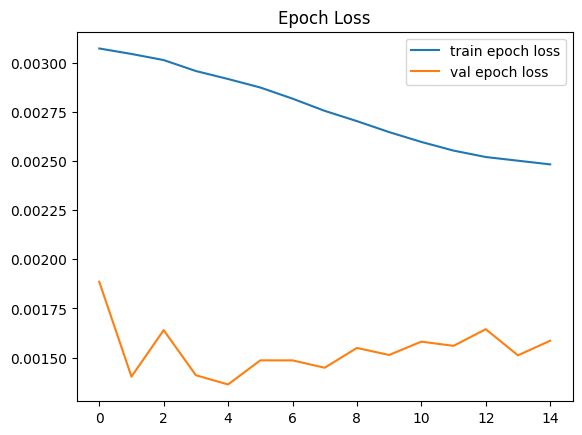

In [22]:
plt.plot(loss_tracker.train_epoch_history, label="train epoch loss")
plt.plot(loss_tracker.val_epoch_history, label="val epoch loss")
plt.legend()
plt.title("Epoch Loss")
plt.show()

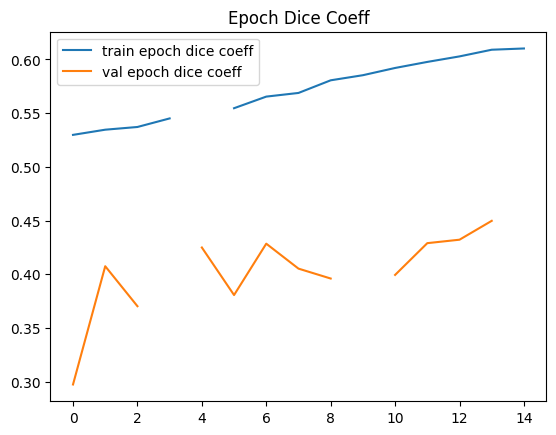

In [23]:
plt.plot(dice_tracker.train_epoch_history, label="train epoch dice coeff")
plt.plot(dice_tracker.val_epoch_history, label="val epoch dice coeff")
plt.legend()
plt.title("Epoch Dice Coeff")
plt.show()